In [22]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import requests

import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report



In [2]:
tf.__version__

'2.9.0'

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Metal device set to: Apple M1 Pro


2023-02-24 11:37:53.863998: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-24 11:37:53.864357: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


True

# get data

In [6]:
def get_ds():
    url = "https://datasets-server.huggingface.co/parquet?dataset=aadityaubhat%2FGPT-wiki-intro"
    response = requests.get(url)
    if response.status_code !=200:
        return f"error during dataset request: {response.status_code}"
    
    url_parquet = [files['url'] for files in response.json()['parquet_files']]
    
    
    df = [pd.read_parquet(url_) for url_ in url_parquet]
    
    return pd.concat(df)

In [15]:
def load_data_in_memory():
    path_data = os.path.join(os.path.dirname(os.path.abspath(os.path.curdir)),'raw_data')
    if 'data.csv' in os.listdir(path_data):
        print('loading local')
        df = pd.read_csv(path_data+'/data.csv',index_col='id')
    else:
        df = get_ds()
        df.set_index('id',inplace=True)
        df['random']=np.random.random(len(df))

        # reorganize ds and randomize samples wiki/generated
        df.loc[df['random']<.5,'text']=df['generated_intro']
        df.loc[df['random']<.5,'label']='generated'
        df.loc[df['random']>=.5,'text']=df['wiki_intro']
        df.loc[df['random']>=.5,'label']='wiki'
        df.to_csv('../raw_data/data.csv')
        
    df['label']=df['label'].replace({'generated':1,'wiki':0})

    return df

In [16]:
df = load_data_in_memory()

loading local


In [7]:
#check distribution is similar accross classes

In [8]:
df[df['label']=='generated'].describe()

,title_len,wiki_intro_len,generated_intro_len,prompt_tokens,generated_text_tokens,random
count,74978.000000,74978.000000,74978.000000,74978.000000,74978.000000,74978.000000
mean,2.213689,196.078716,129.492865,28.938182,165.734816,0.251266
std,0.627942,41.496280,57.087880,5.056070,77.239233,0.144518
min,1.000000,150.000000,7.000000,21.000000,2.000000,0.000007
25%,2.000000,164.000000,86.000000,26.000000,107.000000,0.125750
50%,2.000000,184.000000,122.000000,28.000000,155.000000,0.251661
75%,3.000000,216.000000,170.000000,31.000000,220.000000,0.376973
max,3.000000,350.000000,278.000000,148.000000,300.000000,0.499997


In [9]:
df[df['label']=='wiki'].describe()

,title_len,wiki_intro_len,generated_intro_len,prompt_tokens,generated_text_tokens,random
count,75022.00000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000
mean,2.21707,195.931553,129.445443,28.977327,165.746688,0.749451
std,0.63108,41.392367,56.993277,5.033946,77.203830,0.144789
min,1.00000,150.000000,7.000000,21.000000,1.000000,0.500001
25%,2.00000,164.000000,86.000000,26.000000,107.000000,0.624155
50%,2.00000,184.000000,122.000000,28.000000,155.000000,0.749220
75%,3.00000,216.000000,170.000000,31.000000,220.000000,0.875147
max,3.00000,350.000000,276.000000,116.000000,300.000000,0.999985


In [10]:
X_train,X_test,y_train,y_test = train_test_split(df['text'],df['label'],test_size=.2)

In [11]:
y_train

id
794688           wiki
14687790         wiki
5980344     generated
5539448          wiki
6869216          wiki
              ...    
534977      generated
24432024         wiki
59705       generated
38190265         wiki
49111416         wiki
Name: label, Length: 120000, dtype: object

# Baseline

In [38]:
# vectorize text ; using tfidf
vectorize = TfidfVectorizer(ngram_range=(1,1),max_df=.95,min_df=.05)

#transform
X_train_vect = vectorize.fit_transform(X_train)
X_test_vect = vectorize.transform(X_test)

In [39]:
X_train_vect.shape

(120000, 213)

In [40]:
#NB
model = MultinomialNB()
model.fit(X_train_vect,y_train)

MultinomialNB()

In [41]:
# accuracy of NB model
model.score(X_test_vect,y_test)

0.7454

In [42]:
# classification report 
y_pred = model.predict(X_test_vect)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

   generated       0.72      0.76      0.74     14389
        wiki       0.77      0.73      0.75     15611

    accuracy                           0.75     30000
   macro avg       0.75      0.75      0.75     30000
weighted avg       0.75      0.75      0.75     30000



In [12]:
try:
    X_train_vect = X_train_vect.toarray()
    X_test_vect = X_test_vect.toarray()
except AttributeError:
    pass

if len(X_train_vect.shape)<3:
    X_train_vect = np.expand_dims(X_train_vect,-1)
    X_test_vect = np.expand_dims(X_test_vect,-1)

NameError: name 'X_train_vect' is not defined

# Models

## Simple LSTM

In [42]:
def lstm_model():
    inputs = tf.keras.layers.Input(shape=(X_train_vect[0].shape))
#     inputs = tf.keras.layers.Input(shape=(200,1))
#     x = tf.keras.layers.LSTM(128,return_sequences=True,activation='tanh')(inputs)
    x = tf.keras.layers.LSTM(32,return_sequences=False,activation='tanh')(inputs)
    x = tf.keras.layers.Dense(16,activation='relu')(x)
    outputs = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    
    return tf.keras.Model(inputs=inputs,outputs=outputs)

In [55]:
#compile
lstm = lstm_model()
lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')

In [62]:
#callbacks

#early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=4,restore_best_weights=True)

#tensorboard
log_dir = os.path.join(os.path.abspath(os.path.pardir),'logs','simple_lstm')
tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir,write_graph=False,)

#learning rate
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=.5,patience=3,verbose=1)

In [ ]:
history = lstm.fit(x=X_train_vect,
                   y=np.expand_dims(y_train,-1),
                   validation_split=.2,
                   callbacks=[es,tb,lr],
                   batch_size=32,
                   epochs=50,)

Epoch 1/50
3000/3000 [==============================] - 167s 56ms/step - loss: 0.5606 - accuracy: 0.7086 - val_loss: 0.5541 - val_accuracy: 0.7103 - lr: 5.0000e-04
Epoch 2/50
3000/3000 [==============================] - 168s 56ms/step - loss: 0.5544 - accuracy: 0.7125 - val_loss: 0.5461 - val_accuracy: 0.7162 - lr: 5.0000e-04
Epoch 3/50
3000/3000 [==============================] - 168s 56ms/step - loss: 0.5470 - accuracy: 0.7179 - val_loss: 0.5421 - val_accuracy: 0.7186 - lr: 5.0000e-04
Epoch 4/50
3000/3000 [==============================] - 168s 56ms/step - loss: 0.5436 - accuracy: 0.7224 - val_loss: 0.5391 - val_accuracy: 0.7205 - lr: 5.0000e-04
Epoch 5/50
3000/3000 [==============================] - 169s 56ms/step - loss: 0.5373 - accuracy: 0.7265 - val_loss: 0.5257 - val_accuracy: 0.7348 - lr: 5.0000e-04
Epoch 6/50
3000/3000 [==============================] - 171s 57ms/step - loss: 0.5345 - accuracy: 0.7293 - val_loss: 0.5228 - val_accuracy: 0.7350 - lr: 5.0000e-04
Epoch 7/50
3000/

In [64]:
lstm.save(os.path.join(os.path.abspath(os.path.pardir),'models','simple_lstm'))

INFO:tensorflow:Assets written to: /Users/arthurcollard/code/arthurcol/gpt_vs_human/models/simple_lstm/assets


INFO:tensorflow:Assets written to: /Users/arthurcollard/code/arthurcol/gpt_vs_human/models/simple_lstm/assets


## Using Bidirectional LSTM

In [ ]:
def bilstm_model():
    inputs = tf.keras.layers.Input(shape=(X_train_vect[0].shape))
#     inputs = tf.keras.layers.Input(shape=(200,1))
#     x = tf.keras.layers.LSTM(128,return_sequences=True,activation='tanh')(inputs)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=False,activation='tanh'))(inputs)
    x = tf.keras.layers.Dense(16,activation='relu')(x)
    outputs = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    
    return tf.keras.Model(inputs=inputs,outputs=outputs)

In [ ]:
#compile
bilstm = bilstm_model()
bilstm.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')

In [ ]:
#callbacks

model_name='bi_lstm_2'

#early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3,restore_best_weights=True)

#tensorboard
log_dir = os.path.join(os.path.abspath(os.path.pardir),'logs',model_name)
tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir,write_graph=False,)

#learning rate
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=.5,patience=2,verbose=1)

#model checkpoint
model_path = os.path.join(os.path.abspath(os.path.pardir),'models',model_name)
mc = tf.keras.callbacks.ModelCheckpoint(filepath=model_path,
                                        monitor='val_accuracy',
                                        verbose=1,
                                        save_best_only=True,
                                        save_weights_only=True)

In [ ]:
history = bilstm.fit(x=X_train_vect,
                   y=np.expand_dims(y_train,-1),
                   validation_split=.2,
                   callbacks=[es,tb,lr],
                   batch_size=64,
                   epochs=50,)

## Better embedding with W2V

In [14]:
from gensim.models import Word2Vec

In [15]:
X_train_tokenized = [x.split() for x in X_train]
wv = Word2Vec(sentences=X_train_tokenized,vector_size=50)

In [16]:
def embed_sentence(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)

In [17]:
X_train_vect = [embed_sentence(wv,x) for x in X_train_tokenized]


In [19]:

X_train_pad = tf.keras.utils.pad_sequences(X_train_vect,maxlen=256,truncating='post',padding='post')

In [20]:
def bilstm_model_wv():
    inputs = tf.keras.layers.Input(shape=(X_train_pad[0].shape))
#     inputs = tf.keras.layers.Input(shape=(200,1))
#     x = tf.keras.layers.LSTM(128,return_sequences=True,activation='tanh')(inputs)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=False,activation='tanh'))(inputs)
    x = tf.keras.layers.Dense(16,activation='relu')(x)
    outputs = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    
    return tf.keras.Model(inputs=inputs,outputs=outputs)

In [21]:
#compile
bilstm_wv = bilstm_model_wv()
bilstm_wv.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')

2023-02-23 23:00:52.878804: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-23 23:00:52.878862: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [22]:
#callbacks

model_name='bi_lstm_wv_bis'

#early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3,restore_best_weights=True)

#tensorboard
log_dir = os.path.join(os.path.abspath(os.path.pardir),'logs',model_name)
tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir,write_graph=False,)

#learning rate
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=.5,patience=2,verbose=1)

#model checkpoint
model_path = os.path.join(os.path.abspath(os.path.pardir),'models',model_name)
mc = tf.keras.callbacks.ModelCheckpoint(filepath=model_path,
                                        monitor='val_accuracy',
                                        verbose=1,
                                        save_best_only=True,
                                        save_weights_only=True)

In [23]:
history = bilstm_wv.fit(x=X_train_pad,
                   y=np.expand_dims(y_train,-1),
                   validation_split=.2,
                   callbacks=[es,tb,lr,mc],
                   batch_size=64,
                   epochs=50,)

Epoch 1/50


2023-02-23 23:00:53.289359: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-23 23:00:55.162587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-23 23:00:55.340745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-23 23:00:55.359072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-23 23:00:56.162052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-23 23:00:56.175713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1500/1500 [==============================] - ETA: 0s - loss: 0.3076 - accuracy: 0.8618

2023-02-23 23:03:40.885430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-23 23:03:40.962113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-23 23:03:40.969424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.94233, saving model to /Users/arthurcollard/code/arthurcol/gpt_vs_human/models/bi_lstm_wv_bis
1500/1500 [==============================] - 193s 126ms/step - loss: 0.3076 - accuracy: 0.8618 - val_loss: 0.1570 - val_accuracy: 0.9423 - lr: 0.0010
Epoch 2/50
1500/1500 [==============================] - ETA: 0s - loss: 0.1392 - accuracy: 0.9485
Epoch 2: val_accuracy improved from 0.94233 to 0.95871, saving model to /Users/arthurcollard/code/arthurcol/gpt_vs_human/models/bi_lstm_wv_bis
1500/1500 [==============================] - 191s 128ms/step - loss: 0.1392 - accuracy: 0.9485 - val_loss: 0.1130 - val_accuracy: 0.9587 - lr: 0.0010
Epoch 3/50
1500/1500 [==============================] - ETA: 0s - loss: 0.1023 - accuracy: 0.9628
Epoch 3: val_accuracy improved from 0.95871 to 0.96504, saving model to /Users/arthurcollard/code/arthurcol/gpt_vs_human/models/bi_lstm_wv_bis
1500/1500 [==============================] - 192s 128ms/step - loss: 0.1023 -

In [25]:
X_test_tokenized = [x.split() for x in X_test]
X_test_vect = [embed_sentence(wv,x) for x in X_test_tokenized]
X_test_pad = tf.keras.utils.pad_sequences(X_test_vect,maxlen=256,truncating='post',padding='post')

In [29]:
bilstm_wv.evaluate(X_test_pad,y_test)

2023-02-24 00:05:40.184983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-24 00:05:40.398647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-24 00:05:40.409173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 70s 73ms/step - loss: 0.0927 - accuracy: 0.9775


[0.09268120676279068, 0.9775453209877014]

## Unleash the power of attention models

In [5]:
from transformers import TFBertModel, BertTokenizerFast

/Users/arthurcollard/Library/Caches/pypoetry/virtualenvs/gpt-vs-human-7LNN4CJ4-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
bert = TFBertModel.from_pretrained('bert-base-uncased')

2023-02-23 18:10:44.311637: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-23 18:10:44.311739: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identi

In [7]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [8]:
%%time
lengths = [len(x.split()) for x in X_train]
tokens_raw = tokenizer(list(X_train))

NameError: name 'X_train' is not defined

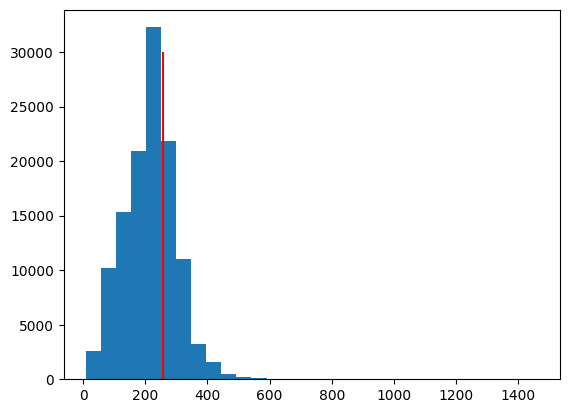

In [114]:
#get lengths
lengths = [len(x) for x in tokens_raw.input_ids]
#check distribution of lengths of tokens
plt.hist(lengths,bins=30);
plt.vlines(x=256,ymin=0,ymax=30000,color='r')

In [129]:
## check proportion
_ = sum(len(el) <= 256 for el in tokens_raw.input_ids)/len(tokens_raw.input_ids)*100

print(f'{_:.2f}% of texts contains less than 256 tokens (not words!)')

69.93% of texts contains less than 256 tokens (not words!)


In [18]:
# tokens with truncation and padding 
tokens_train = tokenizer(list(X_train),padding='max_length',max_length=256,truncation=True)
tokens_test = tokenizer(list(X_test),padding='max_length',max_length=256,truncation=True)

In [19]:
len(tokens_train.input_ids)

120000

In [22]:
tempt_ids = tf.constant(tokens_train.input_ids[:64])
tempt_am = tf.constant(tokens_train.attention_mask[:64])

In [29]:
bert.predict((tempt_ids,tempt_am))#['pooler_output']

2023-02-23 18:15:28.799335: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-23 18:15:31.526755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 4s 386ms/step


TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=array([[[-0.7801033 , -0.599067  ,  0.90572685, ..., -0.56920236,
          0.5780623 ,  0.69011897],
        [-0.739975  , -0.43374944,  0.2817332 , ...,  0.41889942,
          0.7393465 ,  0.65147936],
        [-0.55861485, -0.6715711 ,  0.50482196, ...,  0.2738414 ,
         -0.6503402 , -0.05797983],
        ...,
        [ 0.07825153, -0.42142808, -0.01634572, ..., -0.6980226 ,
          0.49637657,  0.17151695],
        [-1.1665457 , -0.8525289 ,  0.57744056, ...,  0.00438103,
          0.778707  ,  0.07372924],
        [-0.48957533, -0.25351495,  1.5333028 , ..., -0.06921382,
         -0.28163144,  0.25580975]],

       [[-0.23227404, -0.43168655, -0.2812827 , ...,  0.10740367,
          0.349595  ,  0.6542146 ],
        [-0.18368039, -0.18365273,  0.21180208, ...,  0.32206875,
          1.4130634 ,  0.74174243],
        [-0.855635  ,  0.19952285,  0.7871872 , ..., -0.22929859,
         -0.15159139, -0.51795864],
  

In [43]:
def init_bertmodel():
    input_ids = tf.keras.layers.Input(shape=(256),dtype=tf.int32,name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(256),dtype=tf.int32,name='attention_mask')
    
    backbone = TFBertModel.from_pretrained('bert-base-uncased',)
    backbone.trainable = False
    pooler_output = backbone(input_ids,attention_mask)['pooler_output']
    
    
    x = tf.keras.layers.Dense(128,activation='relu')(pooler_output)
    output = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=(input_ids,attention_mask),outputs=output)
    
    return model

In [44]:
#compile
bertmodel = init_bertmodel()
bertmodel.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [45]:
#callbacks

model_name='bertmodel'

#early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3,restore_best_weights=True)

#tensorboard
log_dir = os.path.join(os.path.abspath(os.path.pardir),'logs',model_name)
tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir,write_graph=False,)

#learning rate
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=.5,patience=2,verbose=1)

#model checkpoint
model_path = os.path.join(os.path.abspath(os.path.pardir),'models',model_name)
mc = tf.keras.callbacks.ModelCheckpoint(filepath=model_path,
                                        monitor='val_accuracy',
                                        verbose=1,
                                        save_best_only=True,
                                        save_weights_only=True)

In [ ]:
history = bertmodel.fit(x=ds_b,
#                    y=np.expand_dims(y_train,-1),
#                    validation_split=.2,
                   callbacks=[es,tb,lr],
                   batch_size=64,
                   epochs=50,)

# Features engineering

What kind of FE can we perform ? 
- look at the # of sentences ?
- #words / #sentences
- variance #words / sentences 

In [18]:
df['# sentences'] = df['text'].apply(lambda x : len(x.split('.')))

In [20]:
def word_per_sentence(text):
    sentences = text.split('.')
    lengths = []
    for s in sentences : 
        lengths.append(len(s.split()))
    return [np.mean(np.array(lengths)),np.std(np.array(lengths))]

In [21]:
df_e = pd.concat([
    df,
    df['text'].apply(word_per_sentence)\
                .apply(pd.Series)\
                .rename({0:'mean_w_p_s',1:'var_w_p_s'},axis=1)]
                 ,axis=1)

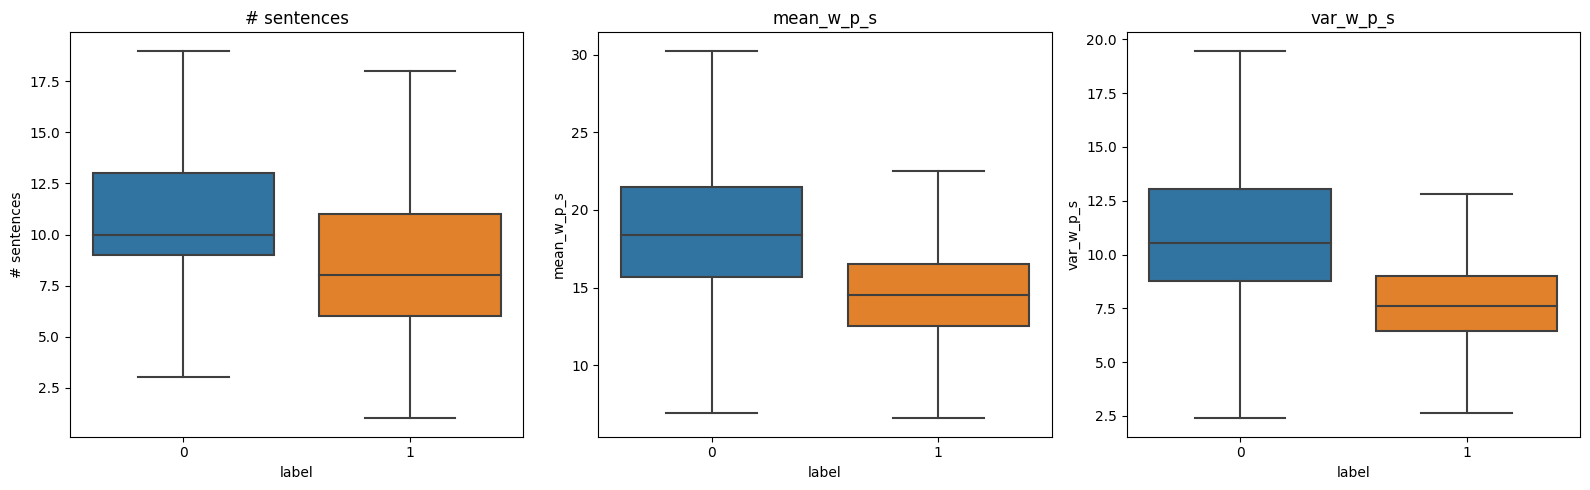

In [58]:
## see if our intuition was good 

fig,axs = plt.subplots(1,3,figsize=(16,5),tight_layout=True)

sns.boxplot(data=df_e,y='# sentences',x='label',ax=axs[0],showfliers=False)
axs[0].set_title('# sentences')

sns.boxplot(data=df_e,y='mean_w_p_s',x='label',ax=axs[1],showfliers=False)
axs[1].set_title('mean_w_p_s')

sns.boxplot(data=df_e,y='var_w_p_s',x='label',ax=axs[2],showfliers=False)
axs[2].set_title('var_w_p_s');


In [59]:
X_train,X_test,y_train,y_test = train_test_split(df_e[['text','# sentences','mean_w_p_s','var_w_p_s']],df['label'])

,text,# sentences,mean_w_p_s,var_w_p_s
id,,,,
2553604,"Wilkie is a surname of Scottish origin, meanin...",7,10.000000,4.720775
3244286,Maramec Spring is located on the Meramec River...,12,12.583333,7.675267
10708388,"José María Ramón Obando del Campo (August 22, ...",14,16.785714,4.753624
69894587,"Pomaderris cocoparrana, commonly known as Coco...",7,14.285714,6.474440
784603,"An ""I quit"" match is a type of professional wr...",3,20.333333,14.522014
...,...,...,...,...
10680343,Phantom Investigators is a 13-episode animated...,6,11.666667,7.203394
1071556,Broadmayne is a village in the English county ...,14,14.928571,8.770603
11336742,Ippolito Buzzi (or Buzio) (1562–1634) was an I...,6,11.833333,7.624886


In [67]:
X_train_tokenized = [x.split() for x in X_train['text']]
wv = Word2Vec(sentences=X_train_tokenized,vector_size=50)

In [68]:
def embed_sentence(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)

In [69]:
X_train_vect = [embed_sentence(wv,x) for x in X_train_tokenized]
X_train_pad = tf.keras.utils.pad_sequences(X_train_vect,maxlen=256,truncating='post',padding='post')

In [72]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
num_scaled_train = scaler.fit_transform(X_train.drop('text',axis=1))
num_scaled_test = scaler.transform(X_test.drop('text',axis=1))

In [85]:
def multi_inputs_model():
    text_inputs = tf.keras.layers.Input(shape=X_train_pad[0].shape,name='text_inputs')
    num_inputs = tf.keras.layers.Input(shape=(3),name='num_inputs')
    
    x_text = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32,return_sequences=False,activation='tanh')
    )(text_inputs)
    out_text = tf.keras.layers.Dense(16,activation='relu')(x_text)
    
    x_num = tf.keras.layers.Dense(32,activation='relu')(num_inputs)
    out_num = tf.keras.layers.Dense(4,activation='relu')(x_num)
    
    x = tf.keras.layers.Concatenate()([out_text,out_num])
    output = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=[text_inputs,num_inputs],outputs=output)
    
    return model 

In [91]:
multimodel = multi_inputs_model()
multimodel.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')

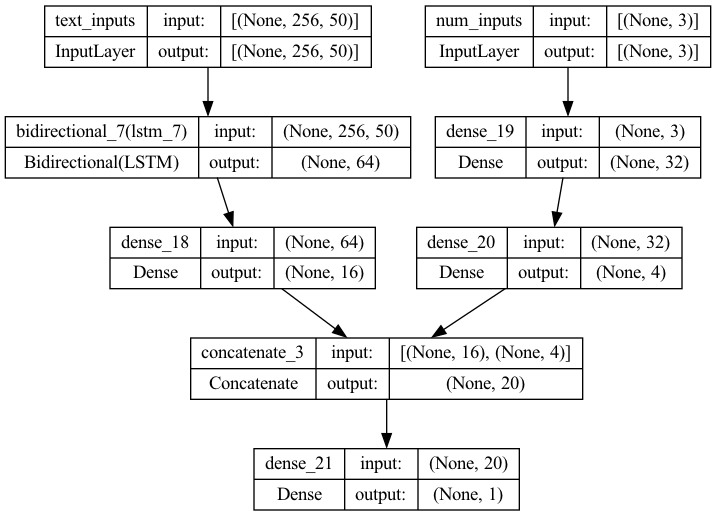

In [92]:
tf.keras.utils.plot_model(multimodel,show_shapes=True)

In [93]:
#callbacks

model_name='multimodel'

#early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3,restore_best_weights=True)

#tensorboard
log_dir = os.path.join(os.path.abspath(os.path.pardir),'logs',model_name)
tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir,write_graph=False,)

#learning rate
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=.5,patience=2,verbose=1)

#model checkpoint
model_path = os.path.join(os.path.abspath(os.path.pardir),'models',model_name)
mc = tf.keras.callbacks.ModelCheckpoint(filepath=model_path,
                                        monitor='val_accuracy',
                                        verbose=1,
                                        save_best_only=True,
                                        save_weights_only=True)

In [94]:
history = multimodel.fit(x={'text_inputs':X_train_pad,'num_inputs':num_scaled_train},
                   y=np.expand_dims(y_train,-1),
                   validation_split=.2,
                   callbacks=[es,tb,lr,mc],
                   batch_size=64,
                   epochs=50,)

Epoch 1/50


2023-02-24 12:27:13.171599: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-24 12:27:15.104578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-24 12:27:15.422316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-24 12:27:15.484130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-24 12:27:16.481402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-24 12:27:16.495790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1407/1407 [==============================] - ETA: 0s - loss: 0.2621 - accuracy: 0.8850

2023-02-24 12:30:01.877785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-24 12:30:01.970729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-24 12:30:01.978381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.93649, saving model to /Users/arthurcollard/code/arthurcol/gpt_vs_human/models/multimodel
1407/1407 [==============================] - 195s 135ms/step - loss: 0.2621 - accuracy: 0.8850 - val_loss: 0.1598 - val_accuracy: 0.9365 - lr: 0.0010
Epoch 2/50
1407/1407 [==============================] - ETA: 0s - loss: 0.1407 - accuracy: 0.9455
Epoch 2: val_accuracy improved from 0.93649 to 0.94773, saving model to /Users/arthurcollard/code/arthurcol/gpt_vs_human/models/multimodel
1407/1407 [==============================] - 185s 132ms/step - loss: 0.1407 - accuracy: 0.9455 - val_loss: 0.1348 - val_accuracy: 0.9477 - lr: 0.0010
Epoch 3/50
1407/1407 [==============================] - ETA: 0s - loss: 0.1022 - accuracy: 0.9620
Epoch 3: val_accuracy improved from 0.94773 to 0.96120, saving model to /Users/arthurcollard/code/arthurcol/gpt_vs_human/models/multimodel
1407/1407 [==============================] - 187s 133ms/step - loss: 0.1022 - accuracy: 0